## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load datasets
print("Loading datasets...")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

# Merge transaction and identity data
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')

print(f"✓ Data loaded and merged: {train_df.shape}")
print(f"  Total features: {train_df.shape[1] - 1} (excluding TransactionID)")

Loading datasets...
✓ Data loaded and merged: (590540, 434)
  Total features: 433 (excluding TransactionID)
✓ Data loaded and merged: (590540, 434)
  Total features: 433 (excluding TransactionID)


## 2. Feature Categorization by Type

In [3]:
# Categorize all features
def categorize_features(df):
    """
    Categorize features by their prefix and type.
    """
    features = {}
    
    # Exclude target and ID
    all_cols = [col for col in df.columns if col not in ['TransactionID', 'isFraud']]
    
    # Categorize by prefix
    features['V_features'] = sorted([col for col in all_cols if col.startswith('V')])
    features['C_features'] = sorted([col for col in all_cols if col.startswith('C')])
    features['D_features'] = sorted([col for col in all_cols if col.startswith('D')])
    features['M_features'] = sorted([col for col in all_cols if col.startswith('M')])
    features['card_features'] = sorted([col for col in all_cols if col.startswith('card')])
    features['addr_features'] = sorted([col for col in all_cols if col.startswith('addr')])
    features['dist_features'] = sorted([col for col in all_cols if col.startswith('dist')])
    features['email_features'] = sorted([col for col in all_cols if 'email' in col.lower()])
    features['device_features'] = sorted([col for col in all_cols if 'device' in col.lower()])
    features['id_features'] = sorted([col for col in all_cols if col.startswith('id')])
    
    # Other features
    categorized = [col for cat_list in features.values() for col in cat_list]
    features['other_features'] = sorted([col for col in all_cols if col not in categorized])
    
    return features

feature_categories = categorize_features(train_df)

print("="*60)
print("FEATURE CATEGORIZATION")
print("="*60)
print(f"\nTotal features (excluding TransactionID and isFraud): {sum(len(v) for v in feature_categories.values())}\n")

for category, cols in feature_categories.items():
    if len(cols) > 0:
        print(f"{category:20s}: {len(cols):3d} features")
        if len(cols) <= 10:
            print(f"  {cols}")
        else:
            print(f"  Examples: {cols[:5]}...")

FEATURE CATEGORIZATION

Total features (excluding TransactionID and isFraud): 434

V_features          : 339 features
  Examples: ['V1', 'V10', 'V100', 'V101', 'V102']...
C_features          :  14 features
  Examples: ['C1', 'C10', 'C11', 'C12', 'C13']...
D_features          :  17 features
  Examples: ['D1', 'D10', 'D11', 'D12', 'D13']...
M_features          :   9 features
  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
card_features       :   6 features
  ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
addr_features       :   2 features
  ['addr1', 'addr2']
dist_features       :   2 features
  ['dist1', 'dist2']
email_features      :   2 features
  ['P_emaildomain', 'R_emaildomain']
device_features     :   2 features
  ['DeviceInfo', 'DeviceType']
id_features         :  38 features
  Examples: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05']...
other_features      :   3 features
  ['ProductCD', 'TransactionAmt', 'TransactionDT']


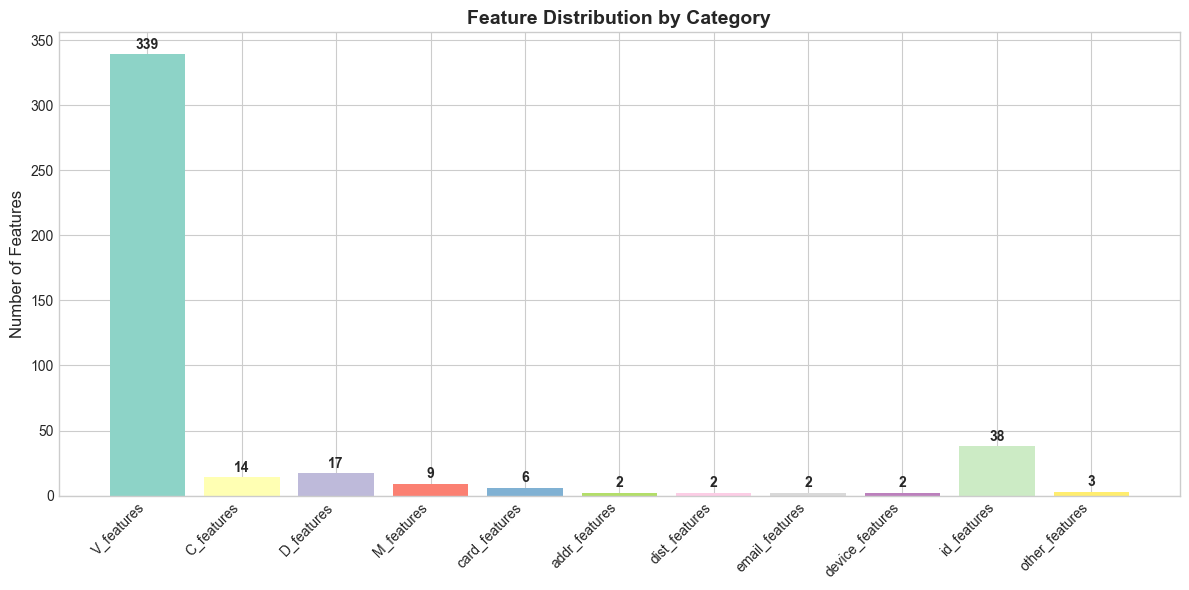

In [4]:
# Visualize feature category distribution
category_counts = {k: len(v) for k, v in feature_categories.items() if len(v) > 0}

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(category_counts)), list(category_counts.values()), 
              color=plt.cm.Set3(np.linspace(0, 1, len(category_counts))))
ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(list(category_counts.keys()), rotation=45, ha='right')
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Distribution by Category', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, category_counts.values())):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Missing Value Pattern Analysis

In [5]:
# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'Feature': train_df.columns,
    'Missing_Count': train_df.isnull().sum().values,
    'Missing_Pct': (train_df.isnull().sum().values / len(train_df) * 100)
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Pct', ascending=False)
missing_stats['Category'] = missing_stats['Feature'].apply(lambda x: 
    'V_features' if x.startswith('V') else
    'C_features' if x.startswith('C') else
    'D_features' if x.startswith('D') else
    'M_features' if x.startswith('M') else
    'card_features' if x.startswith('card') else
    'id_features' if x.startswith('id') else
    'device_features' if 'device' in x.lower() else
    'email_features' if 'email' in x.lower() else
    'other'
)

print("="*60)
print("MISSING VALUE ANALYSIS")
print("="*60)
print(f"\nFeatures with missing values: {len(missing_stats)} / {len(train_df.columns)}")
print(f"Overall missingness: {missing_stats['Missing_Count'].sum() / (len(train_df) * len(train_df.columns)) * 100:.2f}%\n")

# Missing by category
print("Missing values by category:")
for category in missing_stats['Category'].unique():
    cat_missing = missing_stats[missing_stats['Category'] == category]
    print(f"  {category:20s}: {len(cat_missing)} features, avg {cat_missing['Missing_Pct'].mean():.1f}% missing")

print(f"\nTop 20 features with most missing values:")
print(missing_stats.head(20).to_string(index=False))

MISSING VALUE ANALYSIS

Features with missing values: 414 / 434
Overall missingness: 45.07%

Missing values by category:
  id_features         : 38 features, avg 84.8% missing
  other               : 4 features, avg 43.9% missing
  D_features          : 17 features, avg 60.5% missing
  V_features          : 339 features, avg 43.0% missing
  email_features      : 2 features, avg 46.4% missing
  M_features          : 9 features, avg 49.9% missing
  card_features       : 5 features, avg 0.6% missing

Top 20 features with most missing values:
Feature  Missing_Count  Missing_Pct    Category
  id_24         585793    99.196159 id_features
  id_25         585408    99.130965 id_features
  id_07         585385    99.127070 id_features
  id_08         585385    99.127070 id_features
  id_21         585381    99.126393 id_features
  id_26         585377    99.125715 id_features
  id_27         585371    99.124699 id_features
  id_23         585371    99.124699 id_features
  id_22         585371 

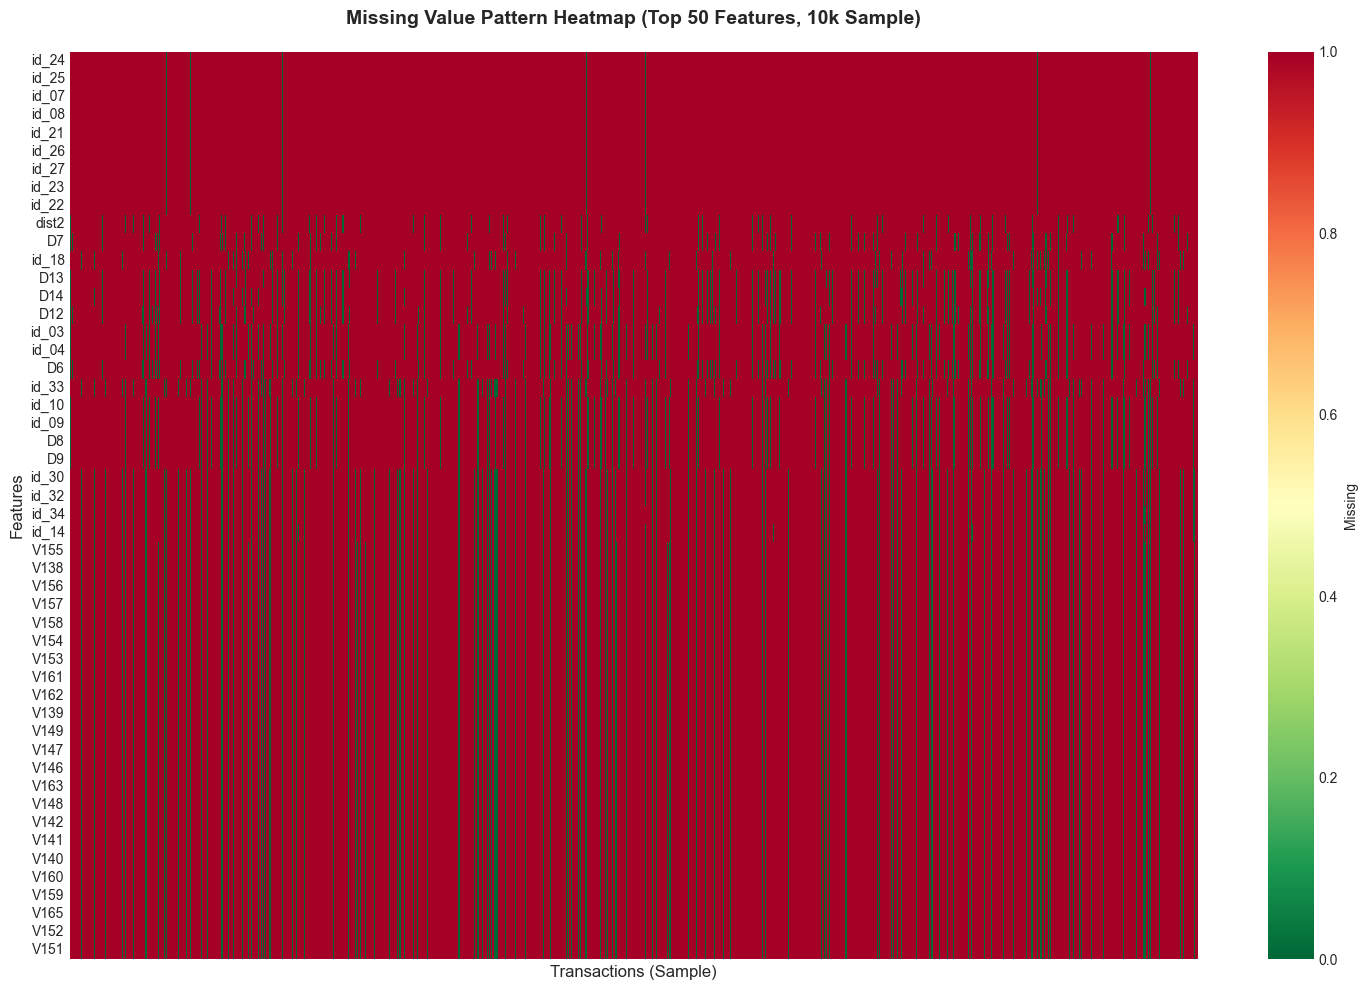

In [6]:
# Visualize missing value patterns - Heatmap
# Select subset of features for visualization
top_missing = missing_stats.head(50)['Feature'].tolist()

# Sample rows for faster visualization
sample_df = train_df[top_missing].sample(n=min(10000, len(train_df)), random_state=42)

plt.figure(figsize=(15, 10))
sns.heatmap(sample_df.isnull().T, cmap='RdYlGn_r', cbar_kws={'label': 'Missing'},
            xticklabels=False, yticklabels=True)
plt.title('Missing Value Pattern Heatmap (Top 50 Features, 10k Sample)', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Features', fontsize=12)
plt.xlabel('Transactions (Sample)', fontsize=12)
plt.tight_layout()
plt.show()

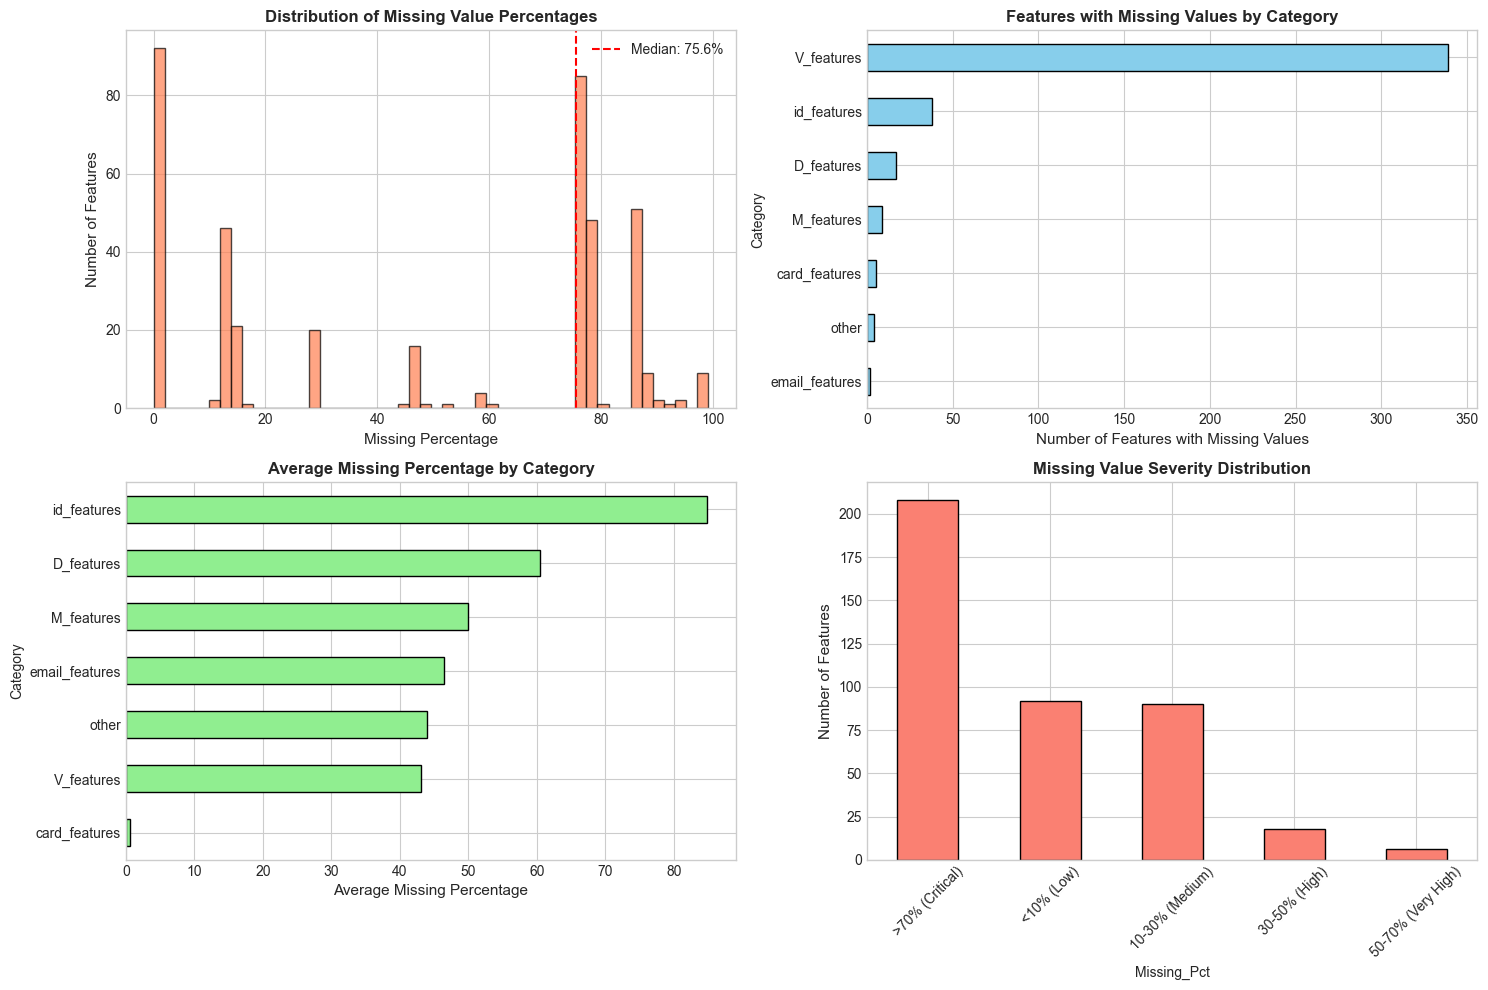

In [7]:
# Missing value distribution by category
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of missing percentages
ax1 = axes[0, 0]
ax1.hist(missing_stats['Missing_Pct'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Missing Percentage', fontsize=11)
ax1.set_ylabel('Number of Features', fontsize=11)
ax1.set_title('Distribution of Missing Value Percentages', fontsize=12, fontweight='bold')
ax1.axvline(missing_stats['Missing_Pct'].median(), color='red', linestyle='--', 
            label=f"Median: {missing_stats['Missing_Pct'].median():.1f}%")
ax1.legend()

# Missing by category
ax2 = axes[0, 1]
category_missing = missing_stats.groupby('Category').size().sort_values(ascending=True)
category_missing.plot(kind='barh', ax=ax2, color='skyblue', edgecolor='black')
ax2.set_xlabel('Number of Features with Missing Values', fontsize=11)
ax2.set_title('Features with Missing Values by Category', fontsize=12, fontweight='bold')

# Average missing % by category
ax3 = axes[1, 0]
category_avg_missing = missing_stats.groupby('Category')['Missing_Pct'].mean().sort_values(ascending=True)
category_avg_missing.plot(kind='barh', ax=ax3, color='lightgreen', edgecolor='black')
ax3.set_xlabel('Average Missing Percentage', fontsize=11)
ax3.set_title('Average Missing Percentage by Category', fontsize=12, fontweight='bold')

# Missing value severity categorization
ax4 = axes[1, 1]
severity = pd.cut(missing_stats['Missing_Pct'], 
                  bins=[0, 10, 30, 50, 70, 100],
                  labels=['<10% (Low)', '10-30% (Medium)', '30-50% (High)', 
                          '50-70% (Very High)', '>70% (Critical)'])
severity.value_counts().plot(kind='bar', ax=ax4, color='salmon', edgecolor='black', rot=45)
ax4.set_ylabel('Number of Features', fontsize=11)
ax4.set_title('Missing Value Severity Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Categorical Features - Cardinality Analysis

In [8]:
# Identify and analyze categorical features
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Also check numeric columns that might be categorical
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
low_cardinality_numeric = [col for col in numeric_cols 
                           if col not in ['TransactionID', 'TransactionDT', 'TransactionAmt', 'isFraud']
                           and train_df[col].nunique() < 100]

all_categorical = categorical_cols + low_cardinality_numeric

print("="*60)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)
print(f"\nObject type features: {len(categorical_cols)}")
print(f"Low-cardinality numeric features (<100 unique): {len(low_cardinality_numeric)}")
print(f"Total categorical features: {len(all_categorical)}")

# Analyze cardinality
cardinality_stats = pd.DataFrame({
    'Feature': all_categorical,
    'Unique_Values': [train_df[col].nunique() for col in all_categorical],
    'Missing_Pct': [train_df[col].isnull().sum() / len(train_df) * 100 for col in all_categorical],
    'Data_Type': [train_df[col].dtype for col in all_categorical]
}).sort_values('Unique_Values', ascending=False)

# Categorize by cardinality
cardinality_stats['Cardinality'] = pd.cut(cardinality_stats['Unique_Values'],
                                           bins=[0, 5, 20, 50, 100],
                                           labels=['Very Low (≤5)', 'Low (6-20)', 
                                                   'Medium (21-50)', 'High (51-100)'],
                                           include_lowest=True)

print(f"\nCardinality distribution:")
print(cardinality_stats['Cardinality'].value_counts().sort_index())

print(f"\nTop 30 categorical features by unique values:")
print(cardinality_stats.head(30).to_string(index=False))

CATEGORICAL FEATURES ANALYSIS

Object type features: 31
Low-cardinality numeric features (<100 unique): 248
Total categorical features: 279

Cardinality distribution:
Cardinality
Very Low (≤5)      49
Low (6-20)        118
Medium (21-50)     69
High (51-100)      40
Name: count, dtype: int64

Top 30 categorical features by unique values:
   Feature  Unique_Values  Missing_Pct Data_Type   Cardinality
DeviceInfo           1786    79.905510    object           NaN
     id_33            260    87.589494    object           NaN
     id_31            130    76.245132    object           NaN
      V285             96     0.002032   float64 High (51-100)
     id_26             95    99.125715   float64 High (51-100)
     id_08             94    99.127070   float64 High (51-100)
      V298             94     0.002032   float64 High (51-100)
      V296             94     0.214888   float64 High (51-100)
     id_05             93    76.823755   float64 High (51-100)
      V229             91    7

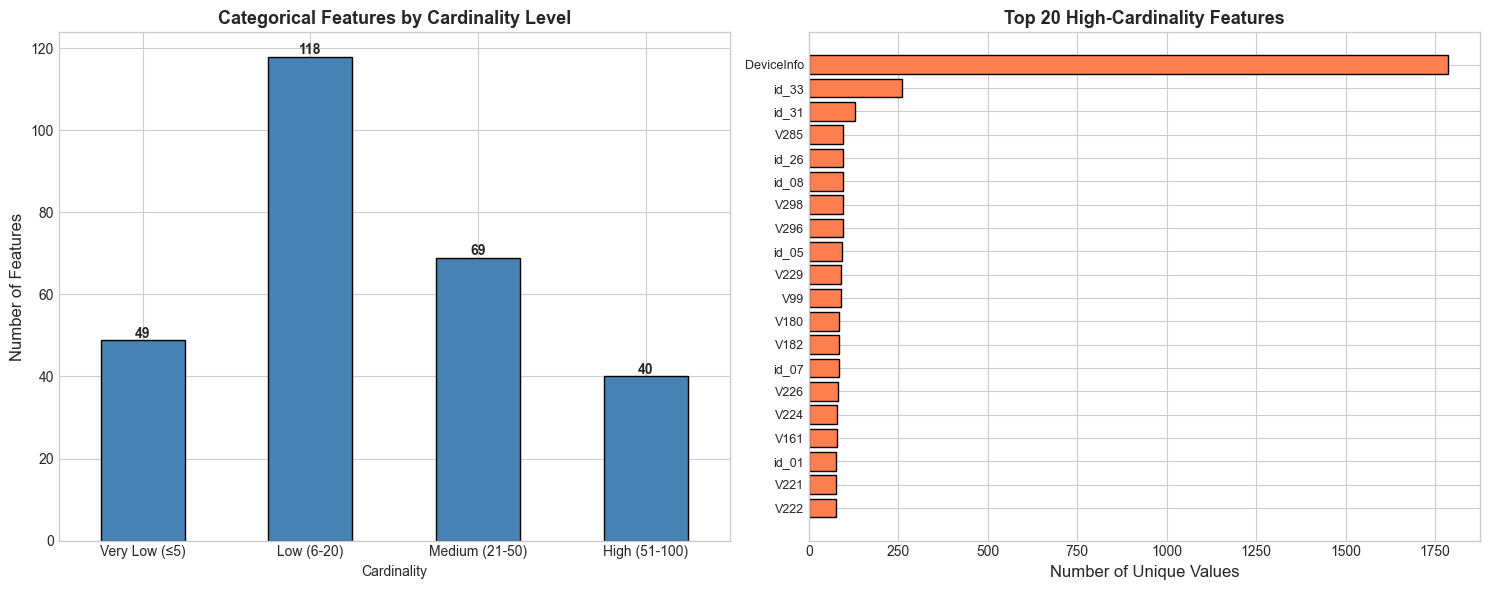

In [9]:
# Visualize cardinality
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cardinality distribution
ax1 = axes[0]
cardinality_stats['Cardinality'].value_counts().sort_index().plot(
    kind='bar', ax=ax1, color='steelblue', edgecolor='black', rot=0)
ax1.set_ylabel('Number of Features', fontsize=12)
ax1.set_title('Categorical Features by Cardinality Level', fontsize=13, fontweight='bold')
for i, v in enumerate(cardinality_stats['Cardinality'].value_counts().sort_index()):
    ax1.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Top 20 high-cardinality features
ax2 = axes[1]
top_20_card = cardinality_stats.head(20)
ax2.barh(range(len(top_20_card)), top_20_card['Unique_Values'], color='coral', edgecolor='black')
ax2.set_yticks(range(len(top_20_card)))
ax2.set_yticklabels(top_20_card['Feature'], fontsize=9)
ax2.set_xlabel('Number of Unique Values', fontsize=12)
ax2.set_title('Top 20 High-Cardinality Features', fontsize=13, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [10]:
# Examine some key categorical features
key_categoricals = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
                   'M1', 'M2', 'M3', 'DeviceType', 'DeviceInfo']
key_categoricals = [col for col in key_categoricals if col in train_df.columns]

print("\n" + "="*60)
print("KEY CATEGORICAL FEATURES - VALUE DISTRIBUTIONS")
print("="*60)

for col in key_categoricals[:5]:  # Show first 5
    print(f"\n{col}:")
    print(f"  Unique values: {train_df[col].nunique()}")
    print(f"  Missing: {train_df[col].isnull().sum() / len(train_df) * 100:.1f}%")
    print(f"\n  Top 10 values:")
    value_counts = train_df[col].value_counts().head(10)
    for val, count in value_counts.items():
        pct = count / len(train_df) * 100
        print(f"    {val}: {count:,} ({pct:.2f}%)")


KEY CATEGORICAL FEATURES - VALUE DISTRIBUTIONS

ProductCD:
  Unique values: 5
  Missing: 0.0%

  Top 10 values:
    W: 439,670 (74.45%)
    C: 68,519 (11.60%)
    R: 37,699 (6.38%)
    H: 33,024 (5.59%)
    S: 11,628 (1.97%)

card4:
  Unique values: 4
  Missing: 0.3%

  Top 10 values:
    visa: 384,767 (65.16%)
    mastercard: 189,217 (32.04%)
    american express: 8,328 (1.41%)
    discover: 6,651 (1.13%)

card6:
  Unique values: 4
  Missing: 0.3%

  Top 10 values:
    debit: 439,938 (74.50%)
    credit: 148,986 (25.23%)
    debit or credit: 30 (0.01%)
    charge card: 15 (0.00%)

P_emaildomain:
  Unique values: 59
  Missing: 16.0%

  Top 10 values:
    gmail.com: 228,355 (38.67%)
    yahoo.com: 100,934 (17.09%)
    hotmail.com: 45,250 (7.66%)
    anonymous.com: 36,998 (6.27%)
    aol.com: 28,289 (4.79%)
    comcast.net: 7,888 (1.34%)
    icloud.com: 6,267 (1.06%)
    outlook.com: 5,096 (0.86%)
    msn.com: 4,092 (0.69%)
    att.net: 4,033 (0.68%)

R_emaildomain:
  Unique values: 60


## 5. Numerical Features Distribution Analysis

In [11]:
# Select key numerical features for detailed analysis
key_numeric_features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5',
                       'addr1', 'addr2', 'dist1', 'dist2'] + \
                       [f'C{i}' for i in range(1, 15)] + \
                       [f'D{i}' for i in range(1, 11)]

key_numeric_features = [col for col in key_numeric_features if col in train_df.columns]

print("="*60)
print("NUMERICAL FEATURES - BASIC STATISTICS")
print("="*60)

print("\nKey numeric features summary:")
print(train_df[key_numeric_features[:15]].describe())

NUMERICAL FEATURES - BASIC STATISTICS

Key numeric features summary:
       TransactionAmt          card1          card2          card3  \
count   590540.000000  590540.000000  581607.000000  588975.000000   
mean       135.027176    9898.734658     362.555488     153.194925   
std        239.162522    4901.170153     157.793246      11.336444   
min          0.251000    1000.000000     100.000000     100.000000   
25%         43.321000    6019.000000     214.000000     150.000000   
50%         68.769000    9678.000000     361.000000     150.000000   
75%        125.000000   14184.000000     512.000000     150.000000   
max      31937.391000   18396.000000     600.000000     231.000000   

               card5          addr1          addr2          dist1  \
count  586281.000000  524834.000000  524834.000000  238269.000000   
mean      199.278897     290.733794      86.800630     118.502180   
std        41.244453     101.741072       2.690623     371.872026   
min       100.000000    

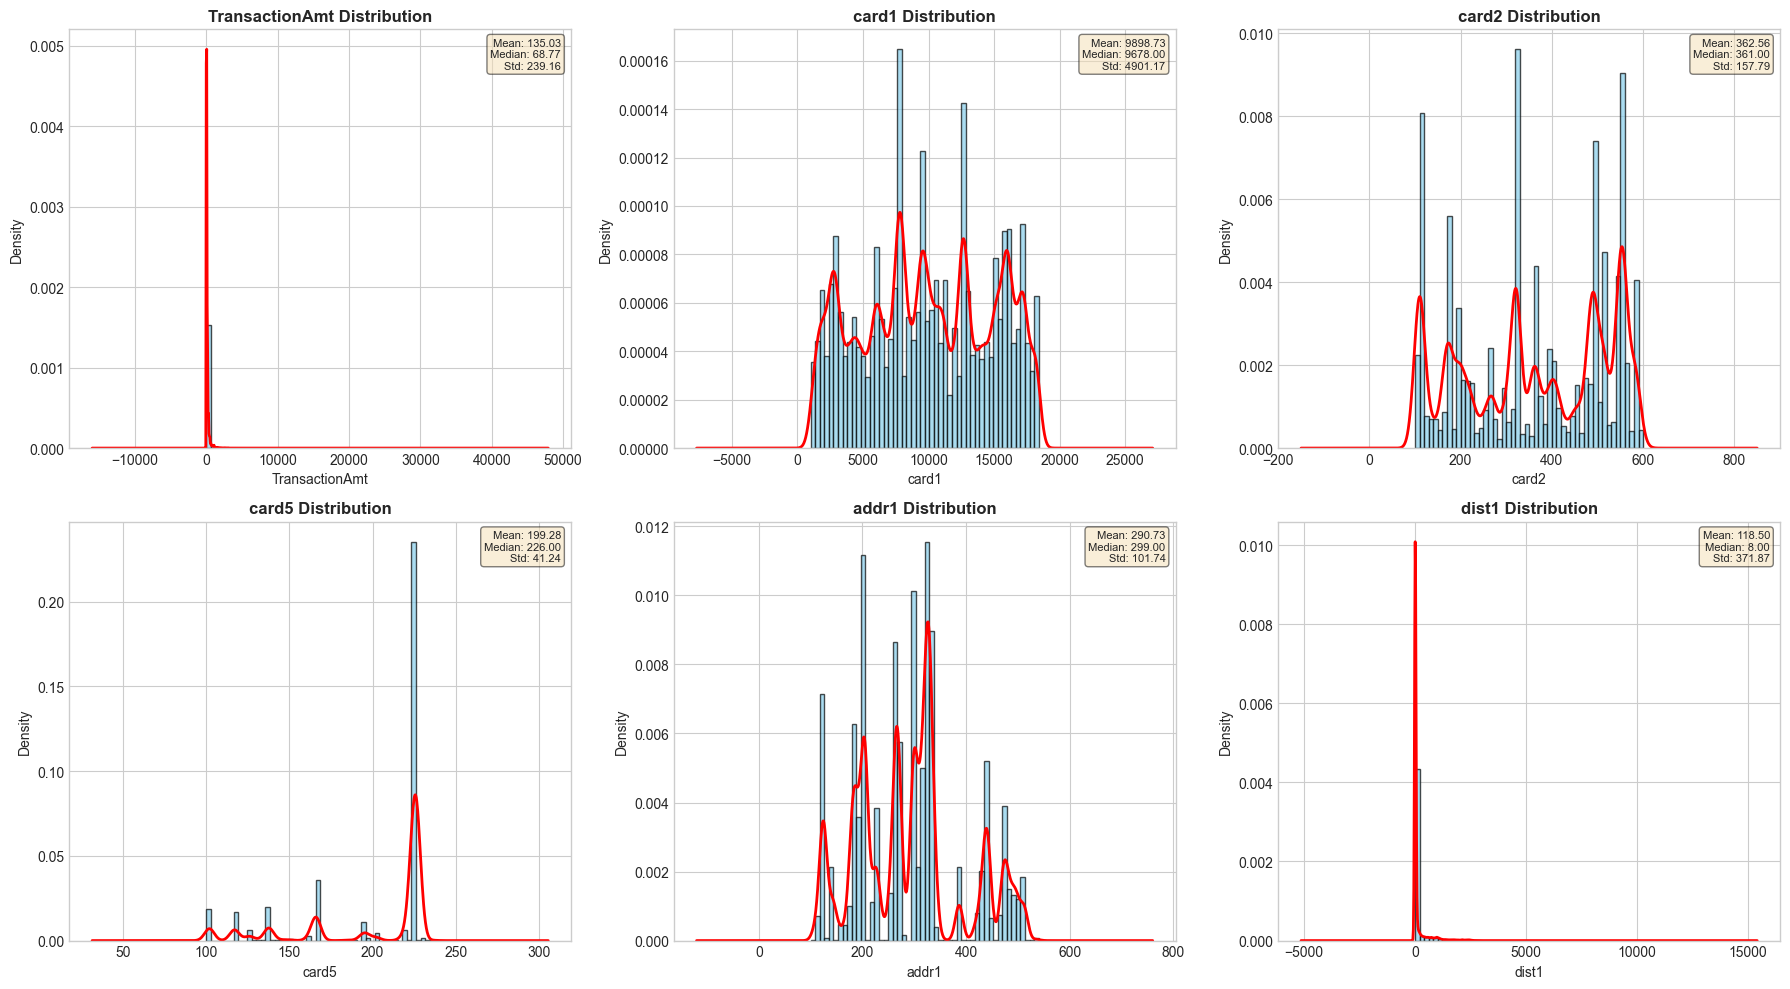

In [12]:
# Distribution analysis for selected features
sample_features = ['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1']
sample_features = [col for col in sample_features if col in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(sample_features):
    ax = axes[idx]
    
    # Remove missing values
    data = train_df[col].dropna()
    
    # Plot histogram with KDE
    data.hist(bins=50, ax=ax, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    data.plot(kind='kde', ax=ax, color='red', linewidth=2, secondary_y=False)
    
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    
    # Add statistics
    stats_text = f"Mean: {data.mean():.2f}\nMedian: {data.median():.2f}\nStd: {data.std():.2f}"
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=8)

plt.tight_layout()
plt.show()

## 6. Feature Distributions: Fraud vs Legitimate

In [13]:
# Compare distributions between fraud and legitimate transactions
comparison_features = ['TransactionAmt', 'card1', 'card2', 'C1', 'C2', 'D1', 'D2', 'D3']
comparison_features = [col for col in comparison_features if col in train_df.columns]

print("="*60)
print("FRAUD VS LEGITIMATE - STATISTICAL COMPARISON")
print("="*60)

for col in comparison_features[:8]:
    fraud_data = train_df[train_df['isFraud'] == 1][col].dropna()
    legit_data = train_df[train_df['isFraud'] == 0][col].dropna()
    
    if len(fraud_data) > 0 and len(legit_data) > 0:
        # Perform statistical test
        statistic, pvalue = stats.mannwhitneyu(fraud_data.sample(min(10000, len(fraud_data))), 
                                                legit_data.sample(min(10000, len(legit_data))),
                                                alternative='two-sided')
        
        print(f"\n{col}:")
        print(f"  Fraud     - Mean: {fraud_data.mean():.2f}, Median: {fraud_data.median():.2f}, Std: {fraud_data.std():.2f}")
        print(f"  Legitimate - Mean: {legit_data.mean():.2f}, Median: {legit_data.median():.2f}, Std: {legit_data.std():.2f}")
        print(f"  Mann-Whitney U test p-value: {pvalue:.4e}")
        print(f"  Significant difference: {'Yes' if pvalue < 0.05 else 'No'}")

FRAUD VS LEGITIMATE - STATISTICAL COMPARISON

TransactionAmt:
  Fraud     - Mean: 149.24, Median: 75.00, Std: 232.21
  Legitimate - Mean: 134.51, Median: 68.50, Std: 239.40
  Mann-Whitney U test p-value: 2.8039e-01
  Significant difference: No

TransactionAmt:
  Fraud     - Mean: 149.24, Median: 75.00, Std: 232.21
  Legitimate - Mean: 134.51, Median: 68.50, Std: 239.40
  Mann-Whitney U test p-value: 2.8039e-01
  Significant difference: No

card1:
  Fraud     - Mean: 9547.65, Median: 9633.00, Std: 4762.05
  Legitimate - Mean: 9911.46, Median: 9711.00, Std: 4905.67
  Mann-Whitney U test p-value: 2.2536e-09
  Significant difference: Yes

card1:
  Fraud     - Mean: 9547.65, Median: 9633.00, Std: 4762.05
  Legitimate - Mean: 9911.46, Median: 9711.00, Std: 4905.67
  Mann-Whitney U test p-value: 2.2536e-09
  Significant difference: Yes

card2:
  Fraud     - Mean: 365.37, Median: 375.00, Std: 159.62
  Legitimate - Mean: 362.45, Median: 361.00, Std: 157.73
  Mann-Whitney U test p-value: 6.1929e

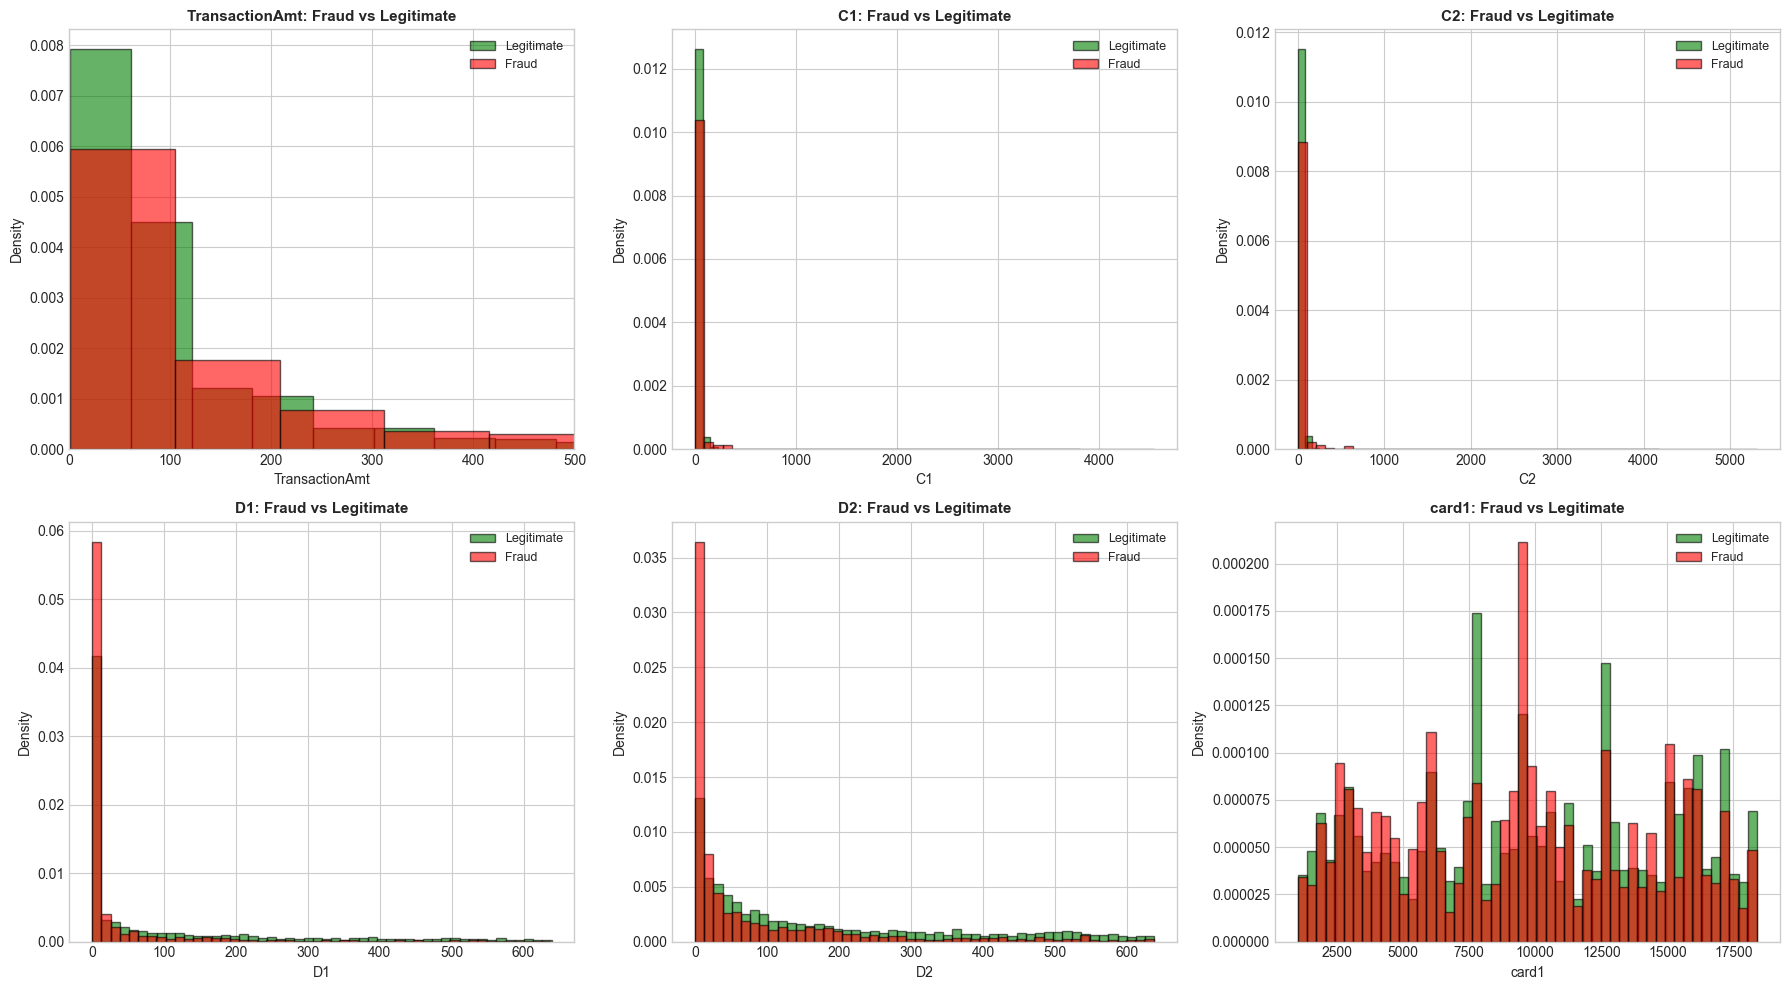

In [14]:
# Visualize fraud vs legitimate distributions
viz_features = ['TransactionAmt', 'C1', 'C2', 'D1', 'D2', 'card1']
viz_features = [col for col in viz_features if col in train_df.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(viz_features):
    ax = axes[idx]
    
    fraud_data = train_df[train_df['isFraud'] == 1][col].dropna()
    legit_data = train_df[train_df['isFraud'] == 0][col].dropna()
    
    # Sample for faster plotting
    if len(fraud_data) > 5000:
        fraud_data = fraud_data.sample(5000, random_state=42)
    if len(legit_data) > 5000:
        legit_data = legit_data.sample(5000, random_state=42)
    
    # Plot distributions
    ax.hist(legit_data, bins=50, alpha=0.6, label='Legitimate', 
            color='green', edgecolor='black', density=True)
    ax.hist(fraud_data, bins=50, alpha=0.6, label='Fraud', 
            color='red', edgecolor='black', density=True)
    
    ax.set_title(f'{col}: Fraud vs Legitimate', fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    
    # Limit x-axis for better visualization
    if col == 'TransactionAmt':
        ax.set_xlim(0, 500)

plt.tight_layout()
plt.show()

## 7. C Features (Count Features) Analysis

In [15]:
# Analyze C columns (count features)
c_features = feature_categories['C_features']

print("="*60)
print("C FEATURES (COUNT FEATURES) ANALYSIS")
print("="*60)
print(f"\nTotal C features: {len(c_features)}")

if len(c_features) > 0:
    print("\nBasic statistics:")
    print(train_df[c_features].describe())
    
    # Missing values in C features
    c_missing = pd.DataFrame({
        'Feature': c_features,
        'Missing_Pct': [train_df[col].isnull().sum() / len(train_df) * 100 for col in c_features]
    }).sort_values('Missing_Pct', ascending=False)
    
    print("\nMissing values:")
    print(c_missing.to_string(index=False))

C FEATURES (COUNT FEATURES) ANALYSIS

Total C features: 14

Basic statistics:
                  C1            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458       5.240343      10.241521       4.076227   
std       133.569018      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         3.000000       0.000000       2.000000       0.000000   
max      4685.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             C2             C3  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       32.539918       8.295215      15.269734       0.005644   
std       129.364844      49.544262     154.668899       0.150536   
min         0.000000    

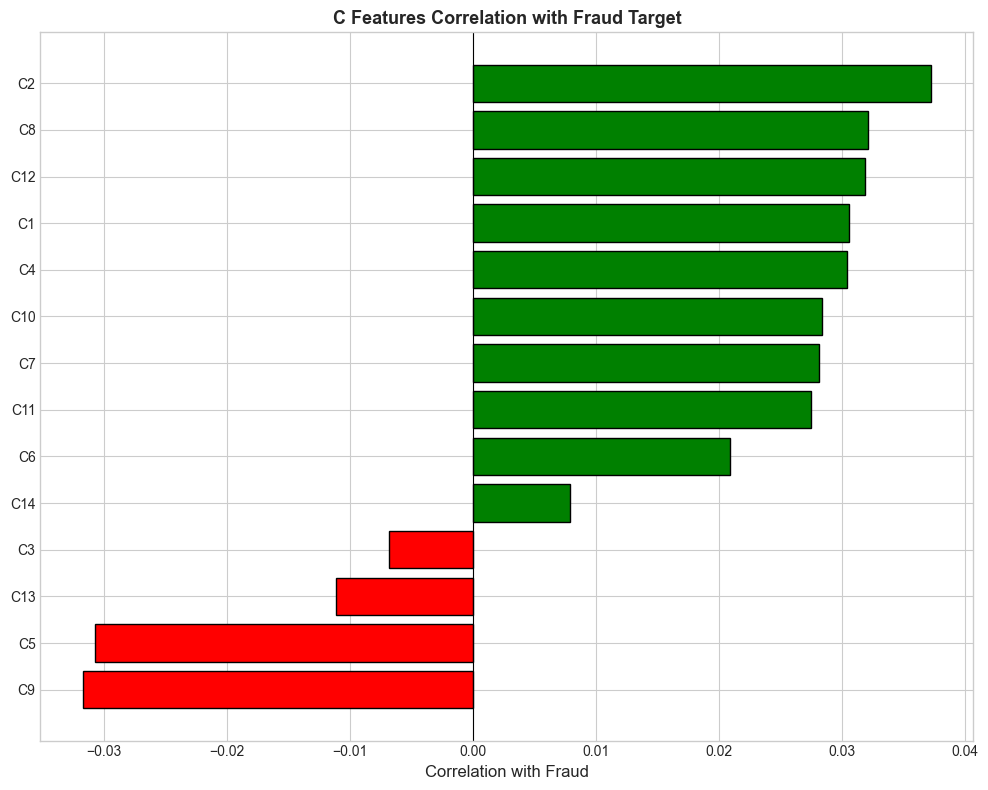


Top 5 C features most correlated with fraud:
C2     0.037229
C8     0.032139
C12    0.031905
C9     0.031703
C5     0.030754
Name: isFraud, dtype: float64


In [16]:
# Visualize C features correlation with fraud
if len(c_features) > 0:
    # Filter to only numeric C features
    numeric_c_features = [col for col in c_features if train_df[col].dtype in ['float64', 'int64']]
    
    if len(numeric_c_features) > 0:
        # Calculate correlation with target
        c_correlations = train_df[numeric_c_features + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values(ascending=False)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['green' if x > 0 else 'red' for x in c_correlations.values]
        ax.barh(range(len(c_correlations)), c_correlations.values, color=colors, edgecolor='black')
        ax.set_yticks(range(len(c_correlations)))
        ax.set_yticklabels(c_correlations.index)
        ax.set_xlabel('Correlation with Fraud', fontsize=12)
        ax.set_title('C Features Correlation with Fraud Target', fontsize=13, fontweight='bold')
        ax.axvline(0, color='black', linewidth=0.8)
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        print("\nTop 5 C features most correlated with fraud:")
        print(c_correlations.abs().sort_values(ascending=False).head())
    else:
        print("\nNo numeric C features available for correlation analysis.")


## 8. D Features (Time Delta Features) Analysis

In [17]:
# Analyze D columns (time delta features)
d_features = feature_categories['D_features']

print("="*60)
print("D FEATURES (TIME DELTA FEATURES) ANALYSIS")
print("="*60)
print(f"\nTotal D features: {len(d_features)}")

if len(d_features) > 0:
    print("\nBasic statistics:")
    print(train_df[d_features].describe())
    
    # Missing values in D features
    d_missing = pd.DataFrame({
        'Feature': d_features,
        'Missing_Pct': [train_df[col].isnull().sum() / len(train_df) * 100 for col in d_features]
    }).sort_values('Missing_Pct', ascending=False)
    
    print("\nMissing values:")
    print(d_missing.to_string(index=False))

D FEATURES (TIME DELTA FEATURES) ANALYSIS

Total D features: 17

Basic statistics:
                  D1            D10            D11           D12  \
count  589271.000000  514518.000000  311253.000000  64717.000000   
mean       94.347568     123.982137     146.621465     54.037533   
std       157.660387     182.615225     186.042622    124.274558   
min         0.000000       0.000000     -53.000000    -83.000000   
25%         0.000000       0.000000       0.000000      0.000000   
50%         3.000000      15.000000      43.000000      0.000000   
75%       122.000000     197.000000     274.000000     13.000000   
max       640.000000     876.000000     670.000000    648.000000   

                D13           D14            D15             D2  \
count  61952.000000  62187.000000  501427.000000  309743.000000   
mean      17.901295     57.724444     163.744579     169.563231   
std       67.614425    136.312450     202.726660     177.315865   
min        0.000000   -193.000000   

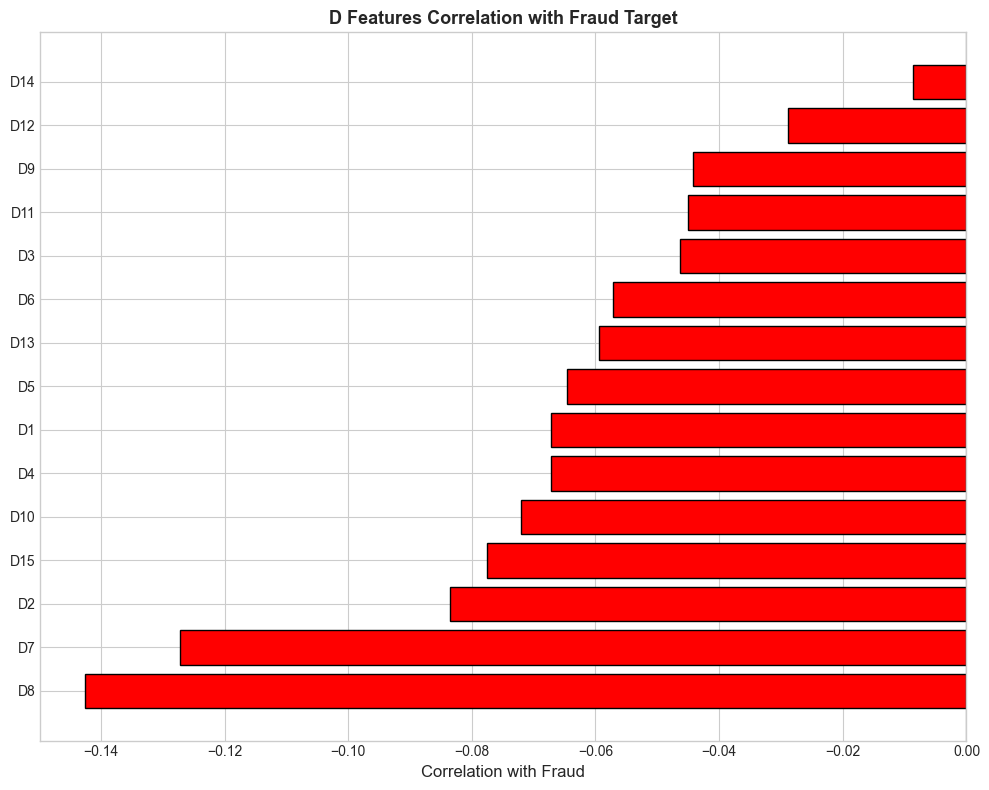


Top 5 D features most correlated with fraud:
D8     0.142636
D7     0.127199
D2     0.083583
D15    0.077519
D10    0.072002
Name: isFraud, dtype: float64


In [18]:
# Visualize D features correlation with fraud
if len(d_features) > 0:
    # Filter to only numeric D features
    numeric_d_features = [col for col in d_features if train_df[col].dtype in ['float64', 'int64']]
    
    if len(numeric_d_features) > 0:
        # Calculate correlation with target
        d_correlations = train_df[numeric_d_features + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values(ascending=False)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['green' if x > 0 else 'red' for x in d_correlations.values]
        ax.barh(range(len(d_correlations)), d_correlations.values, color=colors, edgecolor='black')
        ax.set_yticks(range(len(d_correlations)))
        ax.set_yticklabels(d_correlations.index)
        ax.set_xlabel('Correlation with Fraud', fontsize=12)
        ax.set_title('D Features Correlation with Fraud Target', fontsize=13, fontweight='bold')
        ax.axvline(0, color='black', linewidth=0.8)
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
        
        print("\nTop 5 D features most correlated with fraud:")
        print(d_correlations.abs().sort_values(ascending=False).head())
    else:
        print("\nNo numeric D features available for correlation analysis.")


## 9. V Features (Vesta Engineered Features) Analysis

In [19]:
# Analyze V columns (Vesta's engineered features)
v_features = feature_categories['V_features']

print("="*60)
print("V FEATURES (VESTA ENGINEERED) ANALYSIS")
print("="*60)
print(f"\nTotal V features: {len(v_features)}")
print("Note: These are proprietary features engineered by Vesta Corporation")

if len(v_features) > 0:
    # Sample V features for statistics
    sample_v = v_features[:20]
    print("\nBasic statistics (first 20 V features):")
    print(train_df[sample_v].describe())
    
    # Missing values summary
    v_missing = pd.DataFrame({
        'Feature': v_features,
        'Missing_Pct': [train_df[col].isnull().sum() / len(train_df) * 100 for col in v_features]
    })
    
    print(f"\nV features missing value summary:")
    print(f"  Average missing: {v_missing['Missing_Pct'].mean():.1f}%")
    print(f"  Min missing: {v_missing['Missing_Pct'].min():.1f}%")
    print(f"  Max missing: {v_missing['Missing_Pct'].max():.1f}%")
    print(f"  Features with >50% missing: {(v_missing['Missing_Pct'] > 50).sum()}")

V FEATURES (VESTA ENGINEERED) ANALYSIS

Total V features: 339
Note: These are proprietary features engineered by Vesta Corporation

Basic statistics (first 20 V features):
                  V1            V10           V100           V101  \
count  311253.000000  311253.000000  590226.000000  590226.000000   
mean        0.999945       0.463915       0.273504       0.889249   
std         0.007390       0.521522       0.947176      20.582571   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       0.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       4.000000      28.000000     869.000000   

                V102           V103           V104           V105  \
count  590226.000000  590226.000000  590226.000000  590226.000000   
mean        1.827229       1.279288       0.085433       0.281145   


Top 20 V features most correlated with fraud:
V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
V200    0.318783
V189    0.308219
V188    0.303582
V258    0.297151
V45     0.281832
V158    0.278066
V156    0.275952
V149    0.273282
V228    0.268861
V44     0.260376
V86     0.251828
V87     0.251737
V170    0.249794
V147    0.242894
V52     0.239469
Name: isFraud, dtype: float64


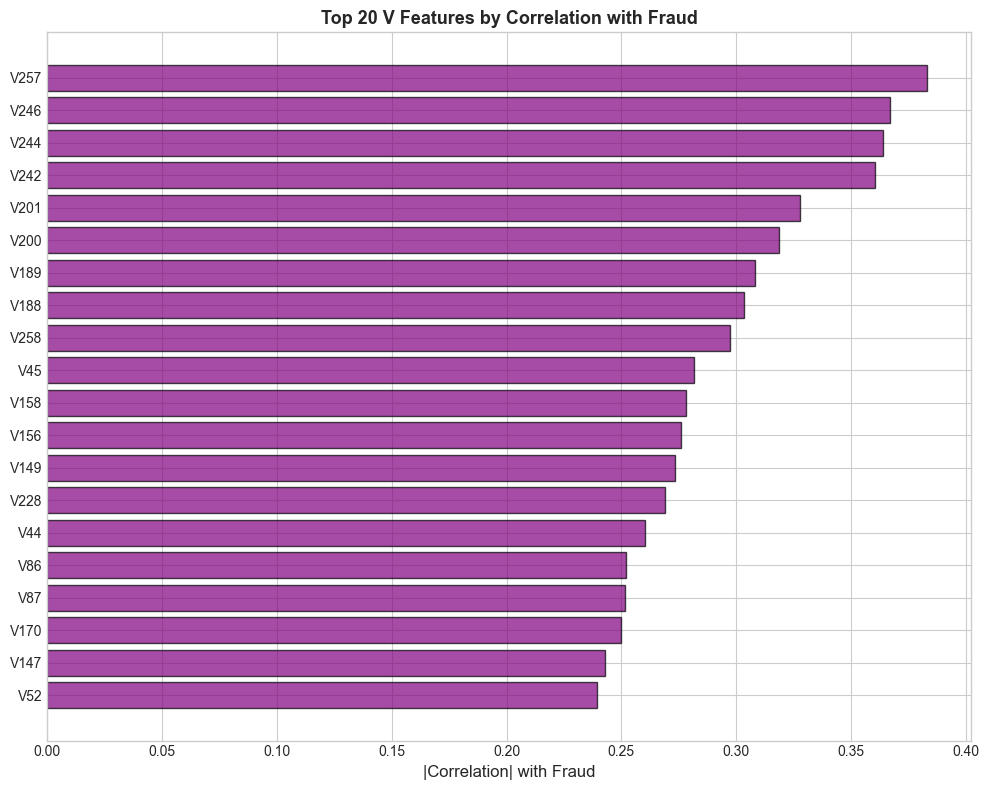

In [20]:
# Top V features by correlation with fraud
if len(v_features) > 0:
    # Filter to only numeric V features
    numeric_v_features = [col for col in v_features if train_df[col].dtype in ['float64', 'int64']]
    
    if len(numeric_v_features) > 0:
        v_correlations = train_df[numeric_v_features + ['isFraud']].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
        
        print("\nTop 20 V features most correlated with fraud:")
        print(v_correlations.head(20))
        
        # Visualize top V features
        fig, ax = plt.subplots(figsize=(10, 8))
        top_20_v = v_correlations.head(20)
        ax.barh(range(len(top_20_v)), top_20_v.values, color='purple', edgecolor='black', alpha=0.7)
        ax.set_yticks(range(len(top_20_v)))
        ax.set_yticklabels(top_20_v.index)
        ax.set_xlabel('|Correlation| with Fraud', fontsize=12)
        ax.set_title('Top 20 V Features by Correlation with Fraud', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo numeric V features available for correlation analysis.")


## 10. Key Insights Summary

In [21]:
# Generate comprehensive insights
print("="*60)
print("KEY INSIGHTS SUMMARY - MILESTONE 2")
print("="*60)

print("\n📊 FEATURE OVERVIEW:")
total_features = sum(len(v) for v in feature_categories.values())
print(f"  • Total features analyzed: {total_features}")
for cat, cols in feature_categories.items():
    if len(cols) > 0:
        print(f"    - {cat}: {len(cols)}")

print("\n❓ MISSING VALUE PATTERNS:")
print(f"  • Features with missing data: {len(missing_stats)} ({len(missing_stats)/len(train_df.columns)*100:.1f}%)")
print(f"  • Overall missingness: {missing_stats['Missing_Count'].sum() / (len(train_df) * len(train_df.columns)) * 100:.2f}%")
print(f"  • Features with >50% missing: {(missing_stats['Missing_Pct'] > 50).sum()}")
print(f"  • Features with >80% missing: {(missing_stats['Missing_Pct'] > 80).sum()}")
print(f"  • Category with most missing: {missing_stats.groupby('Category').size().idxmax()} ({missing_stats.groupby('Category').size().max()} features)")

print("\n🏷️ CATEGORICAL FEATURES:")
print(f"  • Total categorical features: {len(all_categorical)}")
print(f"  • High cardinality (>50 unique): {(cardinality_stats['Unique_Values'] > 50).sum()}")
print(f"  • Medium cardinality (20-50): {((cardinality_stats['Unique_Values'] >= 20) & (cardinality_stats['Unique_Values'] <= 50)).sum()}")
print(f"  • Low cardinality (<20): {(cardinality_stats['Unique_Values'] < 20).sum()}")

print("\n📈 PREDICTIVE SIGNALS:")
# Filter to numeric features for correlation
numeric_c = [col for col in c_features if train_df[col].dtype in ['float64', 'int64']]
numeric_d = [col for col in d_features if train_df[col].dtype in ['float64', 'int64']]
numeric_v = [col for col in v_features if train_df[col].dtype in ['float64', 'int64']]

if len(numeric_c) > 0:
    top_c = train_df[numeric_c + ['isFraud']].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False).iloc[0]
    print(f"  • Best C feature correlation: {top_c:.4f}")
if len(numeric_d) > 0:
    top_d = train_df[numeric_d + ['isFraud']].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False).iloc[0]
    print(f"  • Best D feature correlation: {top_d:.4f}")
if len(numeric_v) > 0:
    top_v = train_df[numeric_v + ['isFraud']].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False).iloc[0]
    print(f"  • Best V feature correlation: {top_v:.4f}")

print("\n💡 KEY OBSERVATIONS:")
print("  1. V features are the most numerous (Vesta's engineered features)")
print("  2. High missingness in many features - need robust imputation strategy")
print("  3. Identity features have limited coverage (~40%) - must handle separately")
print("  4. Significant distributional differences between fraud/legitimate")
print("  5. Multiple feature types suggest ensemble approach may work well")
print("  6. High-cardinality categoricals need careful encoding (card1, DeviceInfo)")

print("\n🎯 RECOMMENDATIONS FOR MODELING:")
print("  • Create meta-features from missing value patterns")
print("  • Use target encoding for high-cardinality categoricals")
print("  • Focus on V, C, and D features with strongest correlations")
print("  • Build separate models for transactions with/without identity info")
print("  • Consider feature selection to reduce dimensionality")
print("  • Use models that handle missing data natively (LightGBM, XGBoost)")

print("\n" + "="*60)
print("✓ MILESTONE 2 COMPLETED")
print("="*60)
print("\nNext: Milestone 3 - Temporal Analysis")


KEY INSIGHTS SUMMARY - MILESTONE 2

📊 FEATURE OVERVIEW:
  • Total features analyzed: 434
    - V_features: 339
    - C_features: 14
    - D_features: 17
    - M_features: 9
    - card_features: 6
    - addr_features: 2
    - dist_features: 2
    - email_features: 2
    - device_features: 2
    - id_features: 38
    - other_features: 3

❓ MISSING VALUE PATTERNS:
  • Features with missing data: 414 (95.4%)
  • Overall missingness: 45.07%
  • Features with >50% missing: 214
  • Features with >80% missing: 74
  • Category with most missing: V_features (339 features)

🏷️ CATEGORICAL FEATURES:
  • Total categorical features: 279
  • High cardinality (>50 unique): 43
  • Medium cardinality (20-50): 72
  • Low cardinality (<20): 164

📈 PREDICTIVE SIGNALS:
  • Best C feature correlation: 0.0372
  • Best C feature correlation: 0.0372
  • Best D feature correlation: 0.1426
  • Best D feature correlation: 0.1426
  • Best V feature correlation: 0.3831

💡 KEY OBSERVATIONS:
  1. V features are the mo

In [22]:
# Save feature taxonomy for future reference
import json

feature_taxonomy = {
    'categories': {k: v for k, v in feature_categories.items()},
    'categorical_features': all_categorical,
    'high_missing_features': missing_stats[missing_stats['Missing_Pct'] > 50]['Feature'].tolist(),
    'high_cardinality_features': cardinality_stats[cardinality_stats['Unique_Values'] > 50]['Feature'].tolist()
}

# This would be saved to file - commented out for notebook
# with open('../config/feature_taxonomy.json', 'w') as f:
#     json.dump(feature_taxonomy, f, indent=2)

print("✓ Feature taxonomy created and ready for export")

✓ Feature taxonomy created and ready for export
